# 卷积神经网络

## 1 读取图像数据

In [1]:
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch
import warnings
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import random
import os
warnings.filterwarnings("ignore")
def set_random_seed(seed_value):
    """设置随机种子"""
    np.random.seed(seed_value)  # NumPy
    random.seed(seed_value)  # Python
    torch.manual_seed(seed_value)  # PyTorch CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)  # PyTorch GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
#设置随机种子
set_random_seed(42)
#设置设备
device='cuda' if torch.cuda.is_available() else 'cpu'

#设置数据集超参数
batch_size=32
img_size=64

#定义图像变换
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),     #统一图像尺寸
    transforms.ToTensor(),                       #将图像转换为张量，且将像素值归一化到[0,1]，不需要手动除255
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )                                            #设置图像归一化参数，此处直接使用ImageNet的均值和标准差
])

#加载训练数据集
train_dataset = datasets.ImageFolder(
    root="data/train",
    transform=transform                                                    
)
#加载验证数据集
val_dataset = datasets.ImageFolder(
    root="data/val",
    transform=transform
)

#加载测试数据集
test_dataset = datasets.ImageFolder(
    root="data/test",
    transform=transform
)

#创建训练数据加载器
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
#创建验证数据加载器
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)
#创建测试数据加载器
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

#查看训练数据集的类别
print(train_dataset.classes)
print(train_dataset.class_to_idx)
#查看训练数据加载器中的一个批次数据
for images, labels in train_loader:
    print(images.shape)
    print(labels)
    break

['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']
{'Bird-drop': 0, 'Clean': 1, 'Dusty': 2, 'Electrical-damage': 3, 'Physical-Damage': 4, 'Snow-Covered': 5}
torch.Size([32, 3, 64, 64])
tensor([3, 4, 0, 4, 5, 4, 0, 0, 1, 5, 1, 3, 2, 3, 2, 0, 4, 0, 0, 2, 2, 0, 1, 2,
        0, 3, 5, 3, 0, 2, 1, 0])


## 2 构建卷积神经网络

In [2]:
class CNN(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()

        # 第一层卷积层
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()  

        # 第二层卷积层
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()  

        # 第三层卷积层
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()  

        # 全连接层
        self.fc1 = nn.Linear(256 * 8 * 8, 512)  # 调整为展平后的大小
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # 第一层
        x = self.relu1(self.bn1(self.conv1(x))) # 64x32x32

        # 第二层
        x = self.relu2(self.bn2(self.conv2(x))) # 128x16x16

        # 第三层
        x = self.relu3(self.bn3(self.conv3(x))) # 256x8x8

        # 展平并通过全连接层
        x = x.reshape(x.size(0), -1)  # 展平操作
        x = self.relu3(self.fc1(x))  # 使用ReLU激活
        x = self.fc2(x)
        
        return x

#定义模型相关超参数
num_classes= 6
lr=0.001
#初始化模型、损失函数、优化器
model=CNN(num_classes=num_classes)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model_name="CNN"

#设置模型权重保存目录
save_path="model_weight"
os.makedirs(save_path,exist_ok=True) #创建模型保存目录(如果没有目录的话)
model_path=os.path.join(save_path,f'{model_name}.pth')

## 3 训练模型

早停在第24个epoch
训练时间: 389.97秒


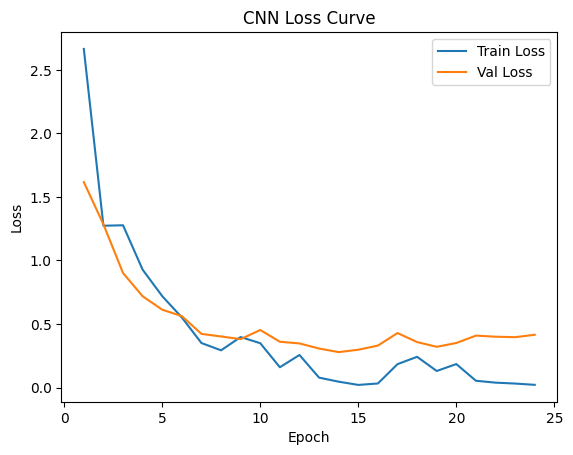

In [3]:
#定义训练相关超参数
epochs=300
patience=10
delta=0.0001

#训练函数
def train(model,model_name):
    start_time=time.time()
    best_loss=float('inf')
    early_stop_count=0
    train_losses=[]
    val_losses=[]
    for epoch in range(1,epochs+1):
        model.train()
        train_loss=0
        for img,label in train_loader:
            img=img.to(device)
            label=label.to(device).long()
            #前向传播
            output=model(img)
            #计算损失
            loss=criterion(output,label)
            #反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #累计损失
            train_loss+=loss.item()
        #计算每个epoch的平均损失
        train_loss/=len(train_loader)
        train_losses.append(train_loss)

        #早停
        #验证模型
        model.eval()
        val_loss=0
        with torch.no_grad():
            for img,label in val_loader:
                img=img.to(device)
                label=label.to(device).long()
                #前向传播
                output=model(img)
                #计算损失
                loss=criterion(output,label)
                #累计损失
                val_loss+=loss.item()
        #计算每个epoch的平均损失
        val_loss/=len(val_loader)
        val_losses.append(val_loss)
        #早停判断
        if val_loss<best_loss-delta:
            best_loss=val_loss
            early_stop_count=0
            #保存最佳模型
            torch.save(model.state_dict(),model_path)
        else:
            early_stop_count+=1
        if early_stop_count>=patience:
            print(f"早停在第{epoch}个epoch")
            end_time=time.time()
            training_time=end_time-start_time
            print(f"训练时间: {training_time:.2f}秒")
            break
    #绘制训练损失曲线图
    plt.plot(range(1,epoch+1),train_losses,label='Train Loss')
    plt.plot(range(1,epoch+1),val_losses,label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Loss Curve')
    plt.legend()
    plt.show()

#训练模型
train(model,model_name)

## 4 测试模型

In [4]:
def test(model,model_name):
    model.to(device)
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for img, label in test_loader:
            img = img.to(device)
            label = label.to(device).long()

            logits = model(img)                 # [B, 6]
            pred = logits.argmax(dim=1)         # [B]

            y_true.append(label.cpu().numpy())
            y_pred.append(pred.cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    return y_true, y_pred

#载入模型参数
model.load_state_dict(torch.load(model_path,map_location=device,weights_only=True))

y_true, y_pred = test(model, model_name)
class_name=train_loader.dataset.classes

print("Test Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4,target_names=class_name))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Test Accuracy: 0.9157894736842105

Classification Report:
                   precision    recall  f1-score   support

        Bird-drop     0.9375    0.8824    0.9091        17
            Clean     0.9412    0.8889    0.9143        18
            Dusty     0.8667    0.8125    0.8387        16
Electrical-damage     1.0000    0.9231    0.9600        13
  Physical-Damage     0.7895    1.0000    0.8824        15
     Snow-Covered     1.0000    1.0000    1.0000        16

         accuracy                         0.9158        95
        macro avg     0.9225    0.9178    0.9174        95
     weighted avg     0.9220    0.9158    0.9163        95


Confusion Matrix:
[[15  0  0  0  2  0]
 [ 0 16  2  0  0  0]
 [ 1  1 13  0  1  0]
 [ 0  0  0 12  1  0]
 [ 0  0  0  0 15  0]
 [ 0  0  0  0  0 16]]
